# Display latent spaces

### Import

In [2]:
%load_ext autoreload
%autoreload 2

import os
PROJECT_PATH = "/projects/compures/alexandre/disdiff_adapters"
os.chdir(PROJECT_PATH)
print(os.getcwd())

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from scipy.special import digamma, gammaln
import numpy as np
from collections import Counter, defaultdict
from math import log
import seaborn as sns
from glob import glob
import json
from pathlib import Path

from torch.utils.data import DataLoader, TensorDataset
from lightning import Trainer, LightningDataModule

from tqdm import tqdm

#DataModule
from disdiff_adapters.data_module import *
#Dataset
from disdiff_adapters.dataset import *
#Module
from disdiff_adapters.arch.multi_distillme import *
#utils
from disdiff_adapters.utils import *
#loss   
from disdiff_adapters.loss import *
#metric
from disdiff_adapters.metric import FactorVAEScore

from disdiff_adapters.arch.multi_distillme.xfactors import Xfactors
BATCH_SIZE = 2**19
LATENT_DIM_S = 126
LATENT_DIM_T = 2
is_pca = False

torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/import/pr_compures/alexandre/disdiff_adapters


In [17]:
ckpt_path_x = load_json(Path("disdiff_adapters/json/ckpt_path_x.json"))

In [11]:
dataset = "dsprites"

### Reset buffers

In [ ]:
xfactors = Xfactors.load_from_checkpoint(ckpt_path_x["126"][dataset]["bt100"]["bs100"]["n-1"])

In [ ]:
xfactors.images_train_buff = torch.load(f"/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/{dataset}/images_train_buff.pt")
xfactors.labels_train_buff = torch.load(f"/projects/compures/alexandre/disdiff_adapters/disdiff_adapters/data/{dataset}/labels_train_buff.pt")

/tmp/ipykernel_557773/4229932485.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xfactors.images_train_buff = torch.load("/projects/compures/alexandre/disdiff_adapters/d

/tmp/ipykernel_557773/4229932485.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xfactors.labels_train_buff = torch.load("/projects/compures/alexandre/disdiff_adapters/d

In [6]:
with torch.no_grad():
    for images in tqdm(xfactors.images_train_buff):
        if images.ndim == 3 : images = images.unsqueeze(0)

        mu_t,_ = xfactors.model.encoder_t(images.to(xfactors.device))
        mu_s,_ = xfactors.model.encoder_s(images.to(xfactors.device))
        xfactors.latent_train_buff["s"].append(mu_s.detach().cpu())
        xfactors.latent_train_buff["t"].append(mu_t.detach().cpu())
if type(xfactors.latent_train_buff["s"])==list : xfactors.latent_train_buff["s"] = torch.cat(xfactors.latent_train_buff["s"])
if type(xfactors.latent_train_buff["t"])==list : xfactors.latent_train_buff["t"] = torch.cat(xfactors.latent_train_buff["t"])

100%|██████████| 701/701 [00:02<00:00, 280.79it/s]


In [7]:
if type(xfactors.images_train_buff)==list: xfactors.images_train_buff = torch.cat(xfactors.images_train_buff)
if type(xfactors.labels_train_buff)==list: xfactors.labels_train_buff = torch.cat(xfactors.labels_train_buff)

In [12]:
if dataset == "dsprites" : xfactors.labels_train_buff = xfactors.labels_train_buff[:, 1:]

### Display latent

In [13]:
assert xfactors.images_train_buff.shape[0] == xfactors.labels_train_buff.shape[0], ""
assert xfactors.latent_train_buff["s"].shape[0] == xfactors.latent_train_buff["t"].shape[0], ""
assert xfactors.latent_train_buff["s"].shape[0] == xfactors.images_train_buff.shape[0]

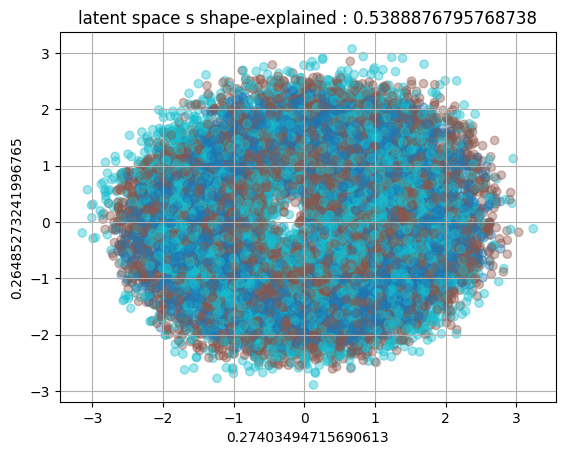

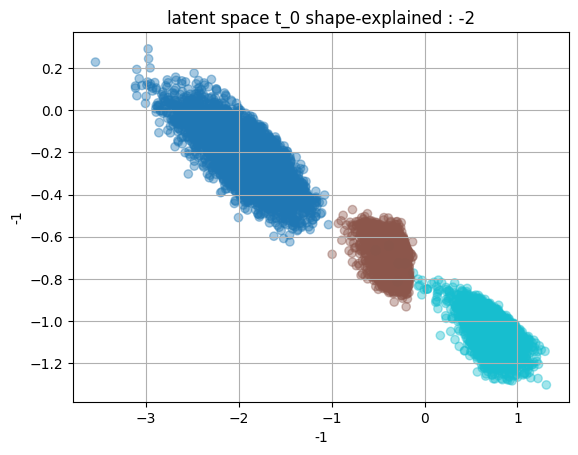

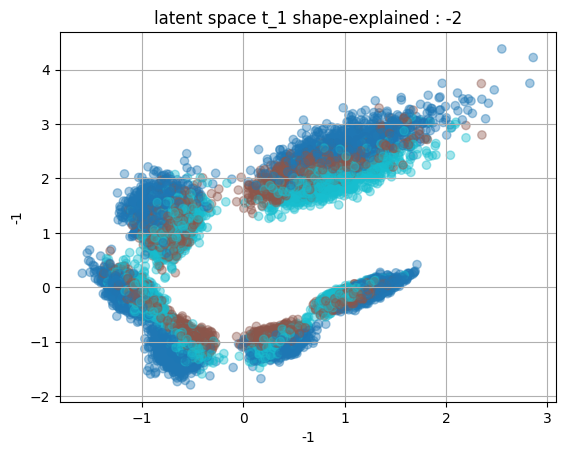

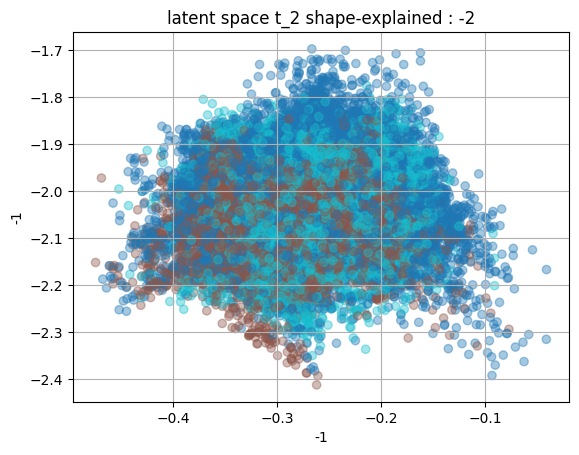

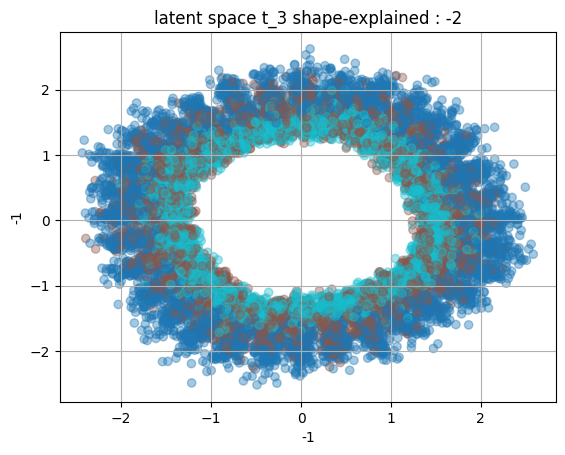

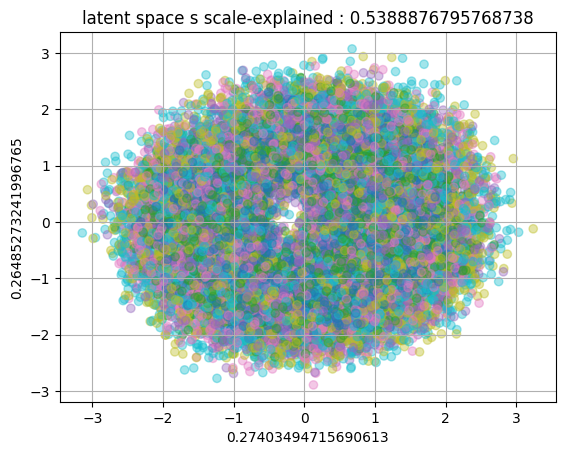

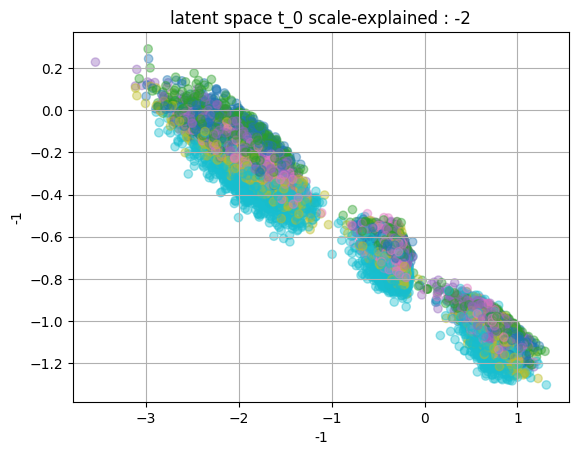

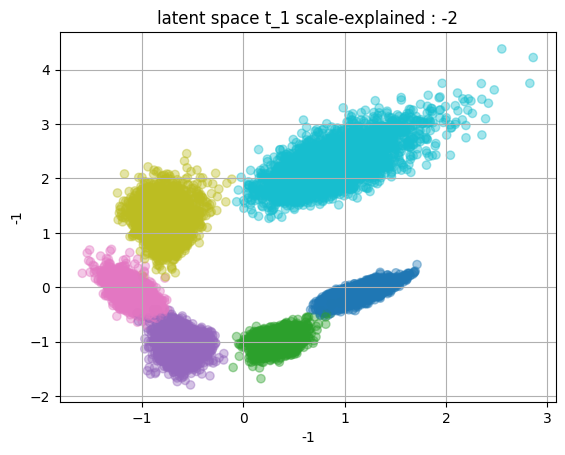

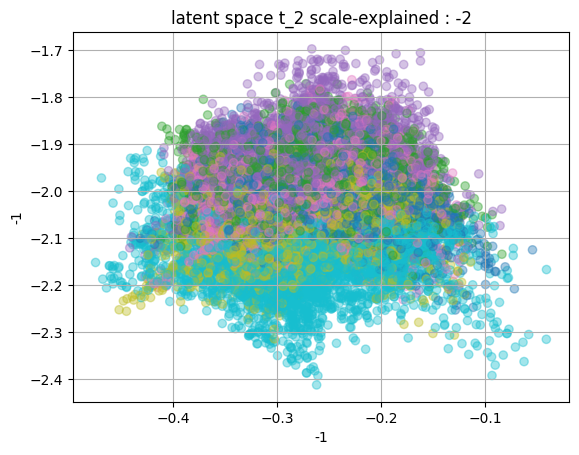

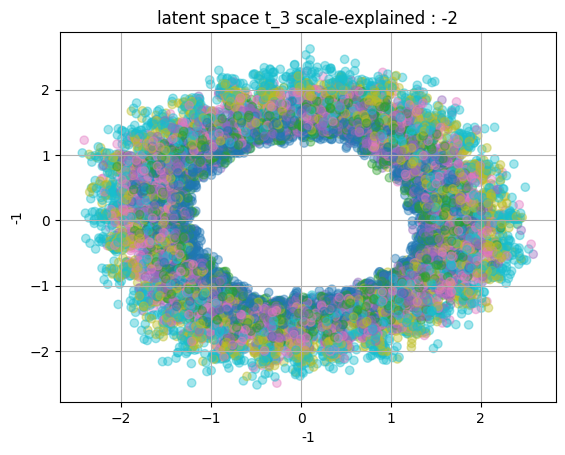

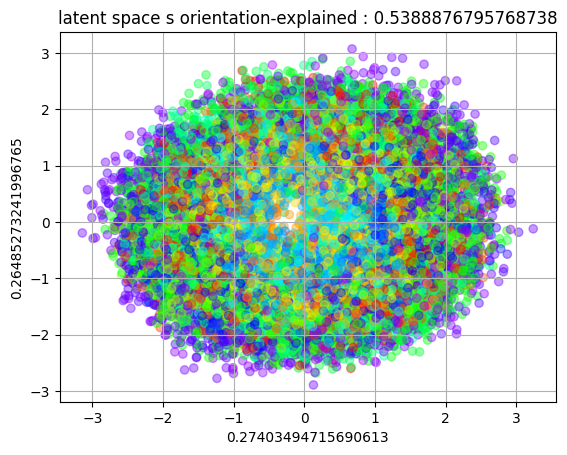

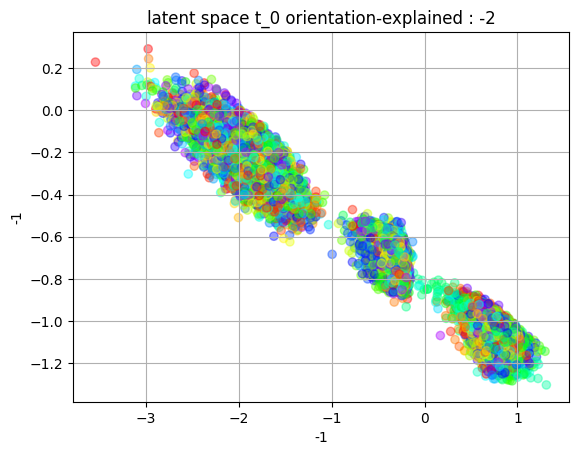

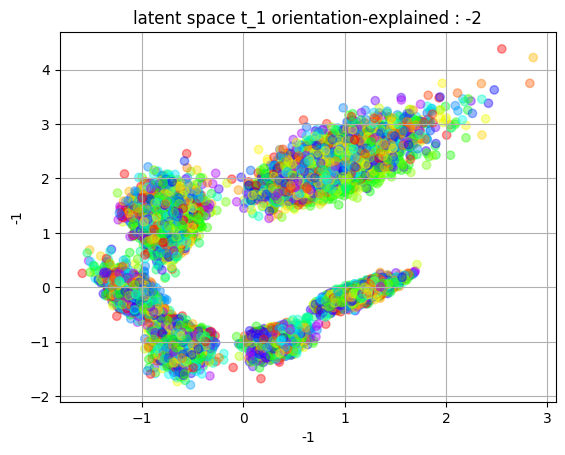

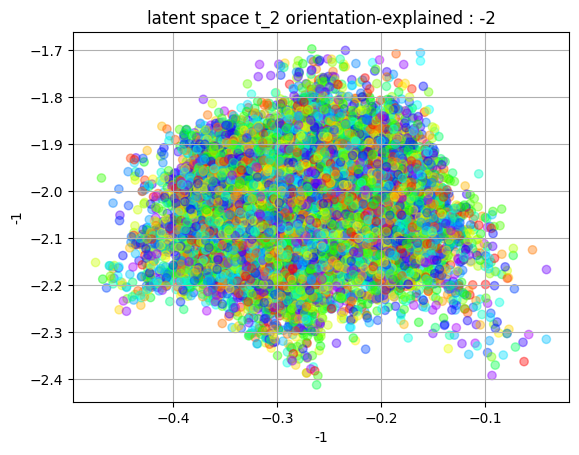

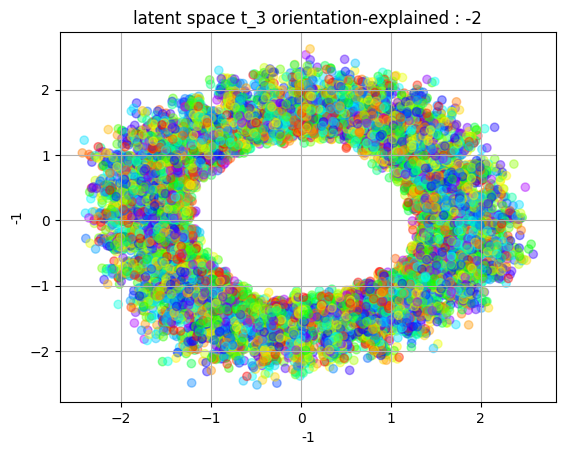

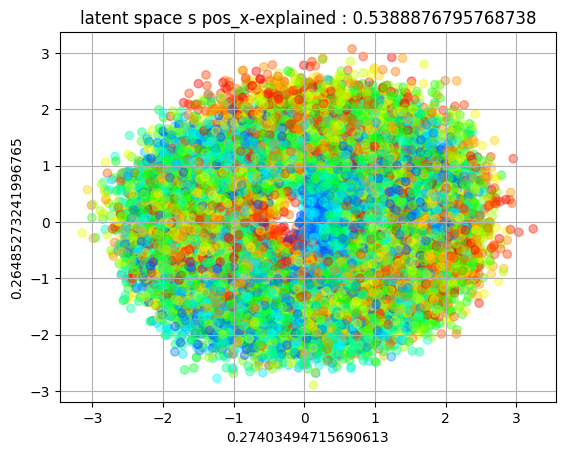

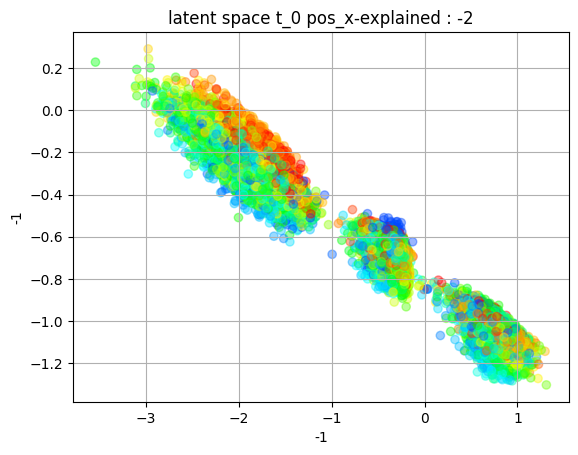

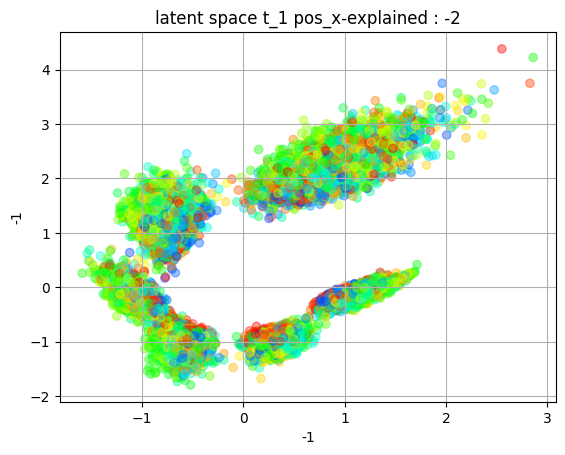

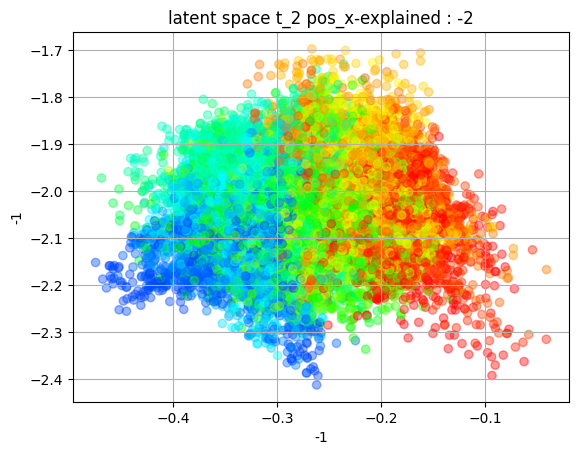

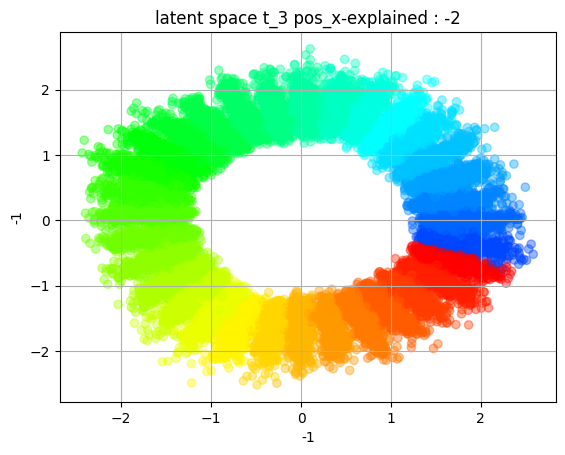

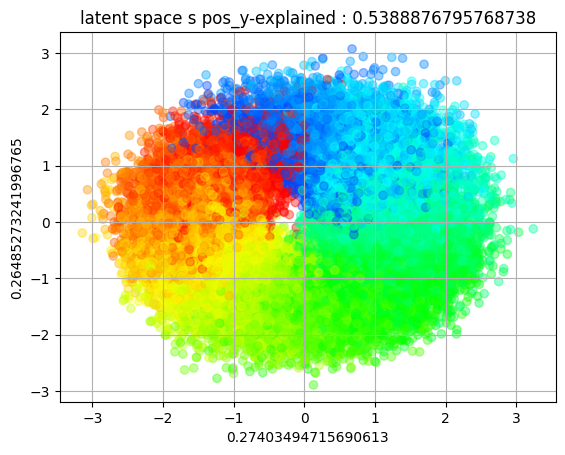

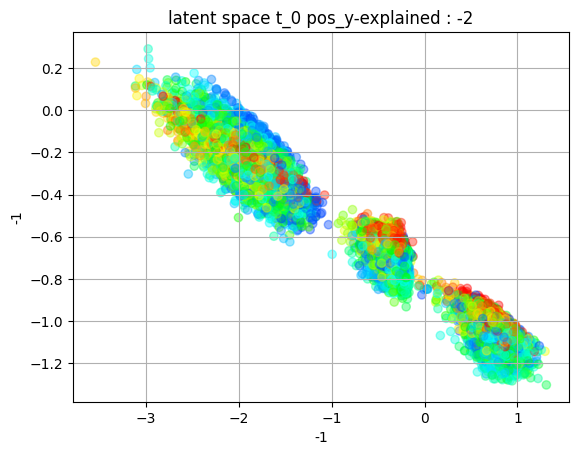

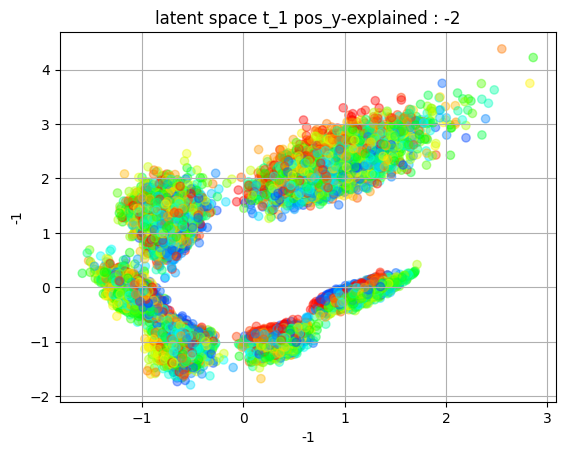

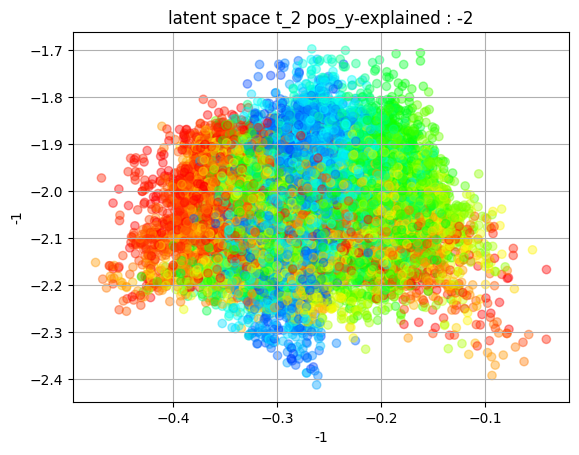

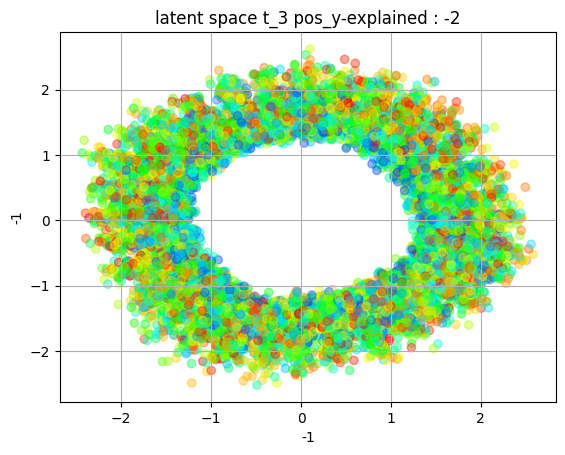

In [14]:
try : os.mkdir(f"latent/epoch_{xfactors.current_epoch}")
except FileExistsError : pass
xfactors.log_latent(log_dir="latent")